In [29]:
# IRIS dataset test example

In [30]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR) 
import keras
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [31]:
# Load the Iris dataset from TensorFlow Datasets
(ds_train, ds_vaidation, ds_test), ds_info = tfds.load(
    'iris',
    split=['train[:60%]','train[60%:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

# Prepare the data: batch, shuffle, and prefetch
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 100

def preprocess(features, label):
    features = tf.cast(features, tf.float64)
    label = tf.cast(label, tf.int32)
    return features, label

ds_train = ds_train.map(preprocess).shuffle(100).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_validation = ds_vaidation.map(preprocess).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Build the neural network model
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(4,), dtype='float64'),
    keras.layers.Dense(12, activation='relu', dtype='float64'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(8, activation='relu', dtype='float64'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(6, activation='relu', dtype='float64'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(3, activation='softmax', dtype='float64')
])

# We use the sparse_categorical_crossentropy loss function when our dataset has labels that are integers, 
# and the categorical_crossentropy loss function when our dataset has one-hot encoded labels. 

# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers#classes

# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses#classes

# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/metrics#classes

# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#compile

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
# Evaluate the UNtrained model on the test dataset
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3042 - loss: 1.1444
Test Loss: 1.1444
Test Accuracy: 0.3000


In [33]:
# Train the model

# %%timeit
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

history = model.fit(ds_train, epochs=EPOCHS, validation_data=ds_validation, callbacks=[early_stopping])

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.3691 - loss: 1.1294 - val_accuracy: 0.2667 - val_loss: 1.1352
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3644 - loss: 1.1115 - val_accuracy: 0.2667 - val_loss: 1.1079
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4566 - loss: 1.0812 - val_accuracy: 0.6000 - val_loss: 1.0739
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5585 - loss: 1.0611 - val_accuracy: 0.6667 - val_loss: 1.0500
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5176 - loss: 1.0446 - val_accuracy: 0.6667 - val_loss: 1.0263
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5541 - loss: 1.0273 - val_accuracy: 0.6667 - val_loss: 1.0044
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5483 - loss: 1.0298 - val_accuracy: 0.6667 - val_loss: 0.9854
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5843 - loss: 1.0085 - val_accuracy: 0.6667 - val_loss: 0.971

In [34]:
# Evaluate the trained model on the test dataset
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8708 - loss: 0.3133
Test Loss: 0.2845
Test Accuracy: 0.9000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 18:20:27.611225: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


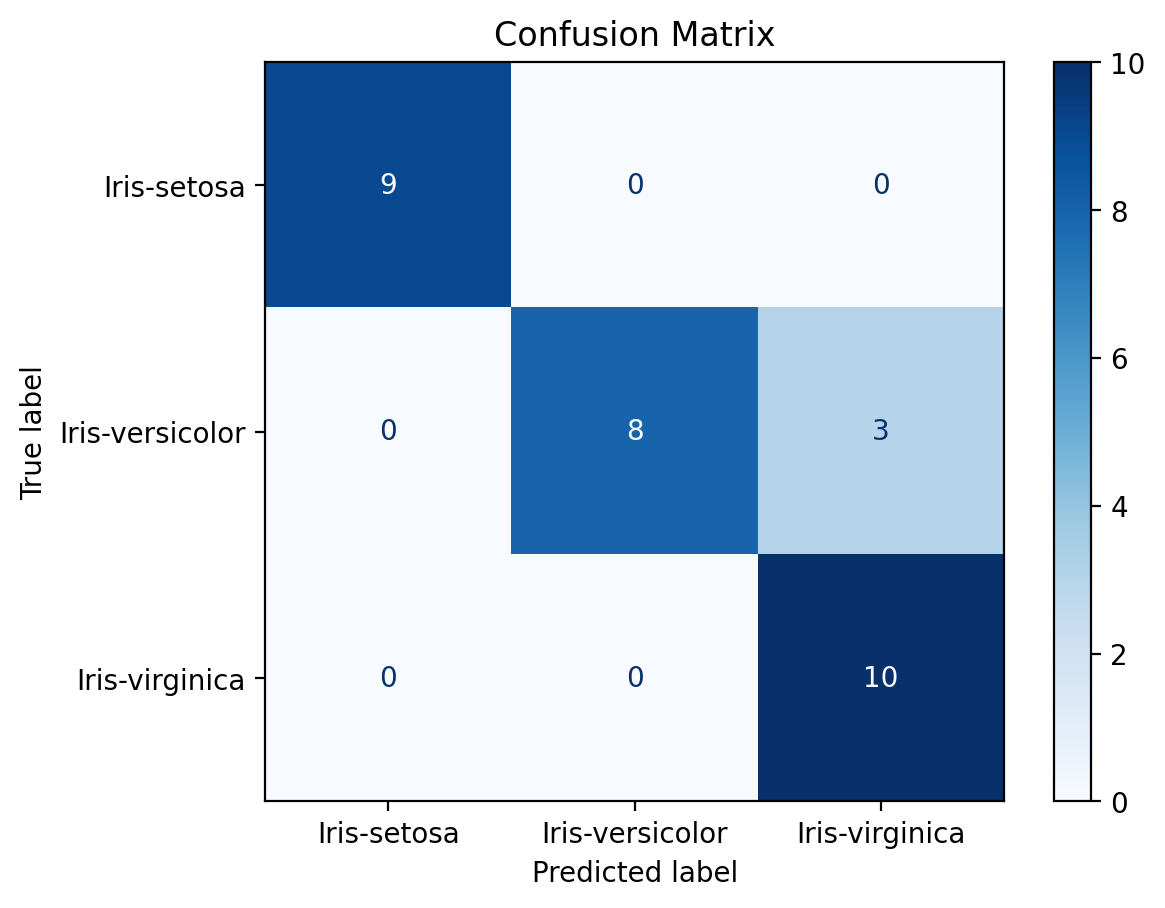

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions from the test set
y_true = []
y_pred = []

for features, labels in ds_test:
    preds = model.predict(features)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ds_info.features['label'].names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [36]:
# Create a random tensor with the same shape as the input features (batch_size, 4)
# BATCH_SIZE
random_features = tf.random.uniform(shape=(1, 4), minval=4.0, maxval=8.0, dtype=tf.float64)

# Get model predictions for the random tensor
random_preds = model.predict(random_features)
predicted_classes = np.argmax(random_preds, axis=1)

print("Random input predictions:", predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Random input predictions: [2]


In [37]:
diagonal_tensor = tf.linalg.diag([42]*5)
print(diagonal_tensor)

tf.Tensor(
[[42  0  0  0  0]
 [ 0 42  0  0  0]
 [ 0  0 42  0  0]
 [ 0  0  0 42  0]
 [ 0  0  0  0 42]], shape=(5, 5), dtype=int32)


In [38]:
predict_dataset = tf.convert_to_tensor([
    [0.3, 0.8, 0.4, 0.5,],
    [0.4, 0.1, 0.8, 0.5,],
    [0.7, 0.9, 0.8, 0.4]
])
predict_dataset

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.3, 0.8, 0.4, 0.5],
       [0.4, 0.1, 0.8, 0.5],
       [0.7, 0.9, 0.8, 0.4]], dtype=float32)>

In [39]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: ")
print(tf.config.list_physical_devices("GPU"))

print("Is the Tensor on GPU #0:  ")
print(x.device.endswith('GPU:0'))

Is there a GPU available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is the Tensor on GPU #0:  
True


In [44]:
import time

def time_matmul(x):
  start = time.time()
  for loop in range(1000):
    tf.linalg.matmul(x, x)

  result = time.time()-start

  print("10 loops: {:0.2f}ms".format(1000*result))

# Force execution on CPU
print("On CPU:")
with tf.device("CPU:0"):
  x = tf.random.uniform([1000, 1000])
  assert x.device.endswith("CPU:0")
  time_matmul(x)

# Force execution on GPU #0 if available
if tf.config.list_physical_devices("GPU"):
  print("On GPU:")
  with tf.device("GPU:0"): # Or GPU:1 for the 2nd GPU, GPU:2 for the 3rd etc.
    x = tf.random.uniform([1000, 1000])
    assert x.device.endswith("GPU:0")
    time_matmul(x)

On CPU:
10 loops: 1963.01ms
On GPU:
10 loops: 25.44ms
